In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error

from toydata import load_binary, load_multiclass, load_regression

# For Binary Problem

In [3]:
X, y = load_binary()

In [4]:
X.shape, y.shape

((569, 30), (569,))

In [5]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<AxesSubplot:>

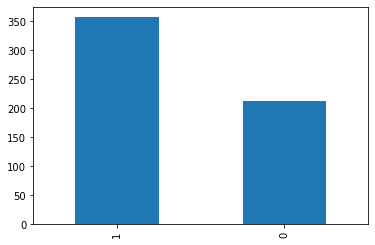

In [6]:
y.value_counts().plot.bar()

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
X_train.shape, X_val.shape

((426, 30), (143, 30))

In [8]:
model = RandomForestClassifier(n_estimators=100, max_depth=3).fit(X_train, y_train)

In [9]:
y_val_prob = model.predict_proba(X_val)[:, 1]
y_val_pred = model.predict(X_val)

In [10]:
val_auc = roc_auc_score(y_val, y_val_prob)
print(f'Val AUC={val_auc}')

Val AUC=0.9953878406708596


In [11]:
val_acc = accuracy_score(y_val, y_val_pred)
print(f'Val ACC={val_acc}')

Val ACC=0.958041958041958


In [12]:
%%time
# scoring names: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
pfimp = permutation_importance(model, X_val, y_val, scoring="accuracy", n_repeats=30, random_state=0)

CPU times: user 10 s, sys: 108 ms, total: 10.2 s
Wall time: 11.2 s


In [13]:
pfimp_score = pd.DataFrame({
    "feature": X.columns,
    "value": pfimp["importances_mean"],
}).sort_values("value").set_index("feature")

pfimp_std = pd.DataFrame({
    "feature": X.columns,
    "value": pfimp["importances_std"],
}).sort_values("value").set_index("feature")

In [14]:
pfimp_score.tail(5)

,value
feature,
worst texture,0.001865
worst concavity,0.002098
worst perimeter,0.007925
worst radius,0.011888
worst area,0.016550


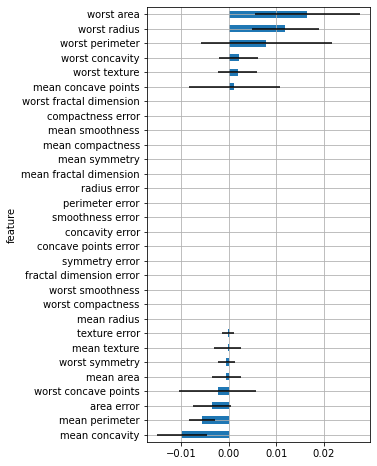

In [15]:
pfimp_score["value"].plot.barh(figsize=(4, 8), xerr=pfimp_std)
plt.grid()

Explain:

- "Làm sai giá trị" / mess up / permute / break `worst area` decrease accuracy score by ~0.03 on validation data. But error bar is **high**! Expected big/smal change in accuracy.

- Break feature `mean concavity` increases score on validation! But error is high too!

In [16]:
X_val_permuted = X_val.copy()
X_val_permuted["worst area"] = np.random.randn(len(X_val))

In [17]:
X_val.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
512,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,16.41,29.66,113.30,844.4,0.15740,0.38560,0.51060,0.20510,0.3585,0.11090
457,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,0.1619,0.05584,...,14.35,34.23,91.29,632.9,0.12890,0.10630,0.13900,0.06005,0.2444,0.06788
439,14.02,15.66,89.59,606.5,0.07966,0.05581,0.02087,0.02652,0.1589,0.05586,...,14.91,19.31,96.53,688.9,0.10340,0.10170,0.06260,0.08216,0.2136,0.06710
298,14.26,18.17,91.22,633.1,0.06576,0.05220,0.02475,0.01374,0.1635,0.05586,...,16.22,25.26,105.80,819.7,0.09445,0.21670,0.15650,0.07530,0.2636,0.07676
37,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,...,13.30,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169


In [18]:
X_val_permuted.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
512,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,16.41,29.66,113.30,1.369439,0.15740,0.38560,0.51060,0.20510,0.3585,0.11090
457,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,0.1619,0.05584,...,14.35,34.23,91.29,-1.109276,0.12890,0.10630,0.13900,0.06005,0.2444,0.06788
439,14.02,15.66,89.59,606.5,0.07966,0.05581,0.02087,0.02652,0.1589,0.05586,...,14.91,19.31,96.53,1.037282,0.10340,0.10170,0.06260,0.08216,0.2136,0.06710
298,14.26,18.17,91.22,633.1,0.06576,0.05220,0.02475,0.01374,0.1635,0.05586,...,16.22,25.26,105.80,-1.520334,0.09445,0.21670,0.15650,0.07530,0.2636,0.07676
37,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,...,13.30,22.81,84.46,0.890780,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169


In [19]:
y_val_permuted_pred = model.predict(X_val_permuted)
accuracy_score(y_val, y_val_permuted_pred)

0.9440559440559441

In [22]:
# Some random permutation will make better acc, some does not change acc
# -> better remove this feature!
X_val_permuted = X_val.copy()
X_val_permuted["mean concavity"] = np.random.randn(len(X_val))
y_val_permuted_pred = model.predict(X_val_permuted)
accuracy_score(y_val, y_val_permuted_pred)

0.965034965034965

# For MultiClass Problem

In [19]:
X, y = load_multiclass()

In [20]:
X.shape, y.shape

((178, 13), (178,))

In [21]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


<AxesSubplot:>

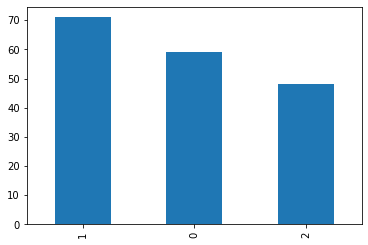

In [22]:
y.value_counts().plot.bar()

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
X_train.shape, X_val.shape

((133, 13), (45, 13))

In [24]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, ).fit(X_train, y_train)

In [25]:
y_val_pred = model.predict(X_val)

In [26]:
val_acc = accuracy_score(y_val, y_val_pred)
print(f'Val ACC={val_acc}')

Val ACC=0.9555555555555556


In [27]:
%%time
# scoring names: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
pfimp = permutation_importance(model, X_val, y_val, scoring="accuracy", n_repeats=30, random_state=0)

CPU times: user 3.73 s, sys: 12.8 ms, total: 3.75 s
Wall time: 3.75 s


In [28]:
pfimp_score = pd.DataFrame({
    "feature": X.columns,
    "value": pfimp["importances_mean"],
}).sort_values("value").set_index("feature")

pfimp_std = pd.DataFrame({
    "feature": X.columns,
    "value": pfimp["importances_std"],
}).sort_values("value").set_index("feature")

In [29]:
pfimp_score.tail(5)

,value
feature,
hue,0.000000
od280/od315_of_diluted_wines,0.004444
proline,0.040000
alcohol,0.057778
color_intensity,0.081481


In [30]:
pfimp_score.head(5)

,value
feature,
total_phenols,-0.010370
alcalinity_of_ash,-0.003704
proanthocyanins,-0.003704
flavanoids,-0.000741
malic_acid,0.000000


<AxesSubplot:ylabel='feature'>

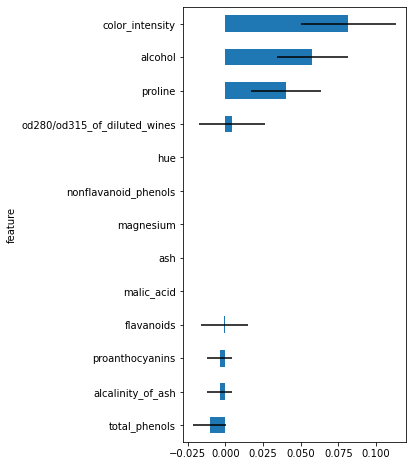

In [31]:
pfimp_score["value"].plot.barh(figsize=(4, 8), xerr=pfimp_std)

Explain:

- Remove `color_intensity` increases accuracy score by ~0.055 on validation data.
- Remove `od280/od315_of_diluted_wines` descreases accuracy score by ~0.022 on validation data.

# For Regression Problem

In [32]:
X, y = load_regression()

In [33]:
X.shape, y.shape

((506, 13), (506,))

In [34]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


<AxesSubplot:ylabel='Frequency'>

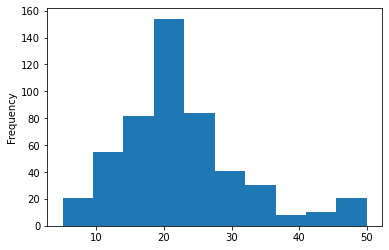

In [35]:
y.plot.hist()

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
X_train.shape, X_val.shape

((379, 13), (127, 13))

In [37]:
model = RandomForestRegressor(n_estimators=100, max_depth=3).fit(X_train, y_train)

In [38]:
y_val_pred = model.predict(X_val)

In [39]:
def root_mean_square_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)**0.5

rmse = make_scorer(root_mean_square_error, greater_is_better=False)

In [40]:
val_rmse = root_mean_square_error(y_val, y_val_pred)
print(f'Val RMSE={val_rmse}')

Val RMSE=4.554735017211266


In [41]:
%%time
# scoring names: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
pfimp = permutation_importance(model, X_val, y_val, scoring=rmse, n_repeats=30, random_state=0)

CPU times: user 3.2 s, sys: 22.3 ms, total: 3.22 s
Wall time: 3.24 s


In [42]:
pfimp_score = pd.DataFrame({
    "feature": X.columns,
    "value": pfimp["importances_mean"],
}).sort_values("value").set_index("feature")

pfimp_std = pd.DataFrame({
    "feature": X.columns,
    "value": pfimp["importances_std"],
}).sort_values("value").set_index("feature")

In [43]:
pfimp_score.tail(5)

,value
feature,
PTRATIO,0.181758
CRIM,0.223625
DIS,0.416178
RM,2.638083
LSTAT,3.466318


In [44]:
pfimp_score.head(5)

,value
feature,
INDUS,-0.007843
CHAS,-0.002099
AGE,-0.001520
ZN,0.000000
B,0.002511


<AxesSubplot:ylabel='feature'>

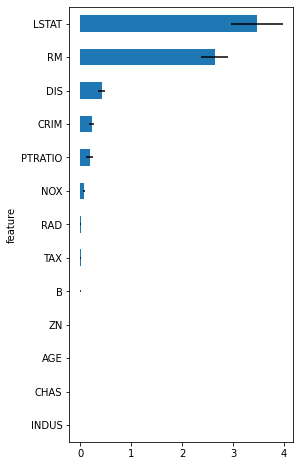

In [45]:
pfimp_score["value"].plot.barh(figsize=(4, 8), xerr=pfimp_std)

Explain:

- Remove `LSTAT` increases rmse score by ~3.6 on validation data.

In [46]:
X_val_permuted = X_val.copy()
X_val_permuted["LSTAT"] = np.random.randn(len(X_val))
y_val_permuted_pred = model.predict(X_val_permuted)
root_mean_square_error(y_val, y_val_permuted_pred)

11.237729009690439

# End